In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.datasets as dset
import torchvision.transforms as tt
import os
from IPython.display import HTML
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.animation as animation
import random
from PIL import Image
import matplotlib.pyplot as plt
import time
import cv2
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from __future__ import print_function
import torch.utils.data
import random
import torch
%matplotlib inline
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import datetime
import argparse
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm.notebook import tqdm




manual_seed = random.randint(1, 10000)
print('Random Seed: ', manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Random Seed:  7650


In [ ]:
Path = "/content/drive/MyDrive/pokemon_jpg"
os.listdir(Path)

['pokemon_jpg']

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


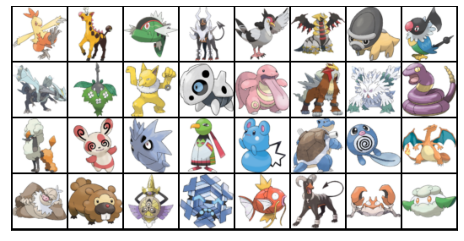

In [ ]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(Path,transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats),
    tt.RandomHorizontalFlip(p=0.5)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)


def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

device = torch.device('cuda:0' if (torch.cuda.is_available() and 1 > 0) else 'cpu')

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( 100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
ngpu = 1
netG = Generator(ngpu).to(device)

if device.type == 'cuda' and ngpu > 1:
    netG = nn.DataParallel(netg, list(range(ngpu)))
    
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator(ngpu).to(device)

if device.type == 'cuda' and ngpu > 1:
    netD = nn.DataParallel(netd, list(range(ngpu)))
    
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, 100, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
lr = 0.0002
num_epochs = 700

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1).float()
        errD_real = criterion(output.float(), label.float())
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output.float(), label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        optimizerD.step()

        # Update Generator network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output.float(), label.float())
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/700][0/7]	Loss_D: 1.4222	Loss_G: 4.3254	D(x): 0.5028	D(G(z)): 0.4028 / 0.0184
[1/700][0/7]	Loss_D: 0.5091	Loss_G: 9.7688	D(x): 0.9433	D(G(z)): 0.3243 / 0.0001
[2/700][0/7]	Loss_D: 0.1735	Loss_G: 7.2212	D(x): 0.8961	D(G(z)): 0.0277 / 0.0011
[3/700][0/7]	Loss_D: 0.0546	Loss_G: 10.5385	D(x): 0.9671	D(G(z)): 0.0002 / 0.0001
[4/700][0/7]	Loss_D: 1.7274	Loss_G: 20.3153	D(x): 0.9892	D(G(z)): 0.7534 / 0.0000
[5/700][0/7]	Loss_D: 0.0830	Loss_G: 11.4618	D(x): 0.9579	D(G(z)): 0.0191 / 0.0000
[6/700][0/7]	Loss_D: 5.5331	Loss_G: 18.6884	D(x): 0.0220	D(G(z)): 0.0000 / 0.0000
[7/700][0/7]	Loss_D: 0.4743	Loss_G: 13.2355	D(x): 0.7163	D(G(z)): 0.0000 / 0.0000
[8/700][0/7]	Loss_D: 0.0827	Loss_G: 11.5952	D(x): 0.9433	D(G(z)): 0.0101 / 0.0000
[9/700][0/7]	Loss_D: 8.2995	Loss_G: 18.8369	D(x): 0.0018	D(G(z)): 0.0000 / 0.0000
[10/700][0/7]	Loss_D: 0.3998	Loss_G: 10.4972	D(x): 0.7584	D(G(z)): 0.0017 / 0.0001
[11/700][0/7]	Loss_D: 0.8724	Loss_G: 6.2634	D(x): 0.7978	D(G(z)): 0.3781 /

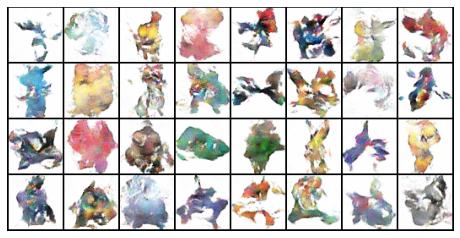

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')
imgs = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

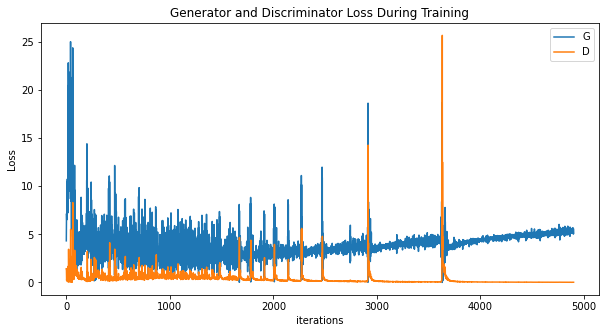

In [15]:
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()